In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import entropy, pearsonr

In [9]:
dtype = {
    'jobId': 'int',
    'jobGroup': 'category',
    'stageId': 'int',
    'taskId': 'int',
    'launchTime': 'int',
    'finishTime': 'int',
    'duration': 'int',
    'schedulerDelay': 'int',
    'executorId': 'int',
    'host': 'category',
    'taskLocality': 'category',
    'speculative': 'bool',
    'gettingResultTime': 'int',
    'successful': 'bool',
    'executorRunTime': 'int',
    'executorCpuTime': 'int',
    'executorDeserializeTime': 'int',
    'executorDeserializeCpuTime': 'int',
    'resultSerializationTime': 'int',
    'jvmGCTime': 'int',
    'resultSize': 'int',
    'numUpdatedBlockStatuses': 'int',
    'diskBytesSpilled': 'int',
    'memoryBytesSpilled': 'int',
    'peakExecutionMemory': 'int',
    'recordsRead': 'int',
    'bytesRead': 'int',
    'recordsWritten': 'int',
    'bytesWritten': 'int',
    'shuffleFetchWaitTime': 'int',
    'shuffleTotalBytesRead': 'int',
    'shuffleTotalBlocksFetched': 'int',
    'shuffleLocalBlocksFetched': 'int',
    'shuffleRemoteBlocksFetched': 'int',
    'shuffleWriteTime': 'int',
    'shuffleBytesWritten': 'int',
    'shuffleRecordsWritten': 'int',
    'phase': 'category',
    'algorithm': 'category',
    'dataset': 'category',
    'family': 'category',
    'platformId': 'int',
    'runId': 'int',
    'splitter': 'category'
}

In [3]:
data = pd.read_csv('../results/platform.csv', header=0, engine='c', na_filter=False, dtype=dtype)

In [10]:
data = pd.read_csv('../results/metrics.csv', header=0, engine='c', na_filter=False, dtype=dtype)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (43,44,45,46,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
small = data[data['platformId'] == 0].drop(columns=[
    'host', 'jobId', 'stageId', 
    'jobGroup', 'taskId', 'launchTime', 
    'finishTime', 'executorId', 'taskLocality', 
    'speculative', 'gettingResultTime', 'successful', 
    'experimentId', 'numUpdatedBlockStatuses', 'diskBytesSpilled', 
    'memoryBytesSpilled', 'recordsWritten', 'bytesWritten', 
    'features', 'mse', 'mae', 'rmse', 'r2', 'family', 'platform', 'platformId', 'runId', 
    'scenarioId', 'splitter', 'workflowId', 'silhouette', 'f1', 
    'weightedPrecision', 'weightedRecall','accuracy', 'testCount', 'trainCount'
], errors='ignore')

In [93]:
def correlations(data, y):

    return pd.DataFrame({
        phase + '-' + algorithm + '-' + dataset:
            correlation(data[(data['algorithm'] == algorithm) & (data['dataset'] == dataset) & (data['phase'] == phase)], y=y)
        for phase in ['transform']
        for algorithm in data['algorithm'].cat.categories.sort_values()
        for dataset in data['dataset'].cat.categories.sort_values()
    })

def remove_nan(data):
    
    if np.isnan(data):
        return 0

    return data

def correlation(data, y):

    return pd.Series({
        feature: remove_nan(pearsonr(data[feature], data[y])[0])
        for feature in data
        if feature not in ['dataset', 'algorithm', 'duration', 'phase', 'fitTime', 'transformTime']
    })

def count(corr, k):
    
    total = {}

    for couple in corr:

        top = corr[couple].abs().nlargest(k).index

        for metric in top:

            if metric not in total:
                total[metric] = 1
            else:
                total[metric] += 1
    
    return total

In [94]:
corr = correlations(small.drop(columns=['executorCpuTime', 'executorDeserializeCpuTime']), 'duration')
total = count(corr, k=4)

In [91]:
pd.Series(total).sort_values()

shuffleRemoteBlocksFetched     2
recordsRead                    2
shuffleTotalBytesRead          4
shuffleTotalBlocksFetched      4
shuffleRecordsWritten          5
resultSerializationTime        6
shuffleBytesWritten            8
peakExecutionMemory            8
bytesRead                     12
resultSize                    14
schedulerDelay                16
jvmGCTime                     24
executorDeserializeTime       30
executorRunTime               45
dtype: int64

In [95]:
pd.Series(total).sort_values()

shuffleFetchWaitTime           2
shuffleRecordsWritten          4
shuffleLocalBlocksFetched      4
shuffleWriteTime               5
shuffleBytesWritten            6
jvmGCTime                      6
resultSerializationTime        6
shuffleTotalBlocksFetched      7
recordsRead                    7
resultSize                    12
shuffleTotalBytesRead         12
shuffleRemoteBlocksFetched    17
schedulerDelay                21
executorDeserializeTime       35
executorRunTime               36
dtype: int64

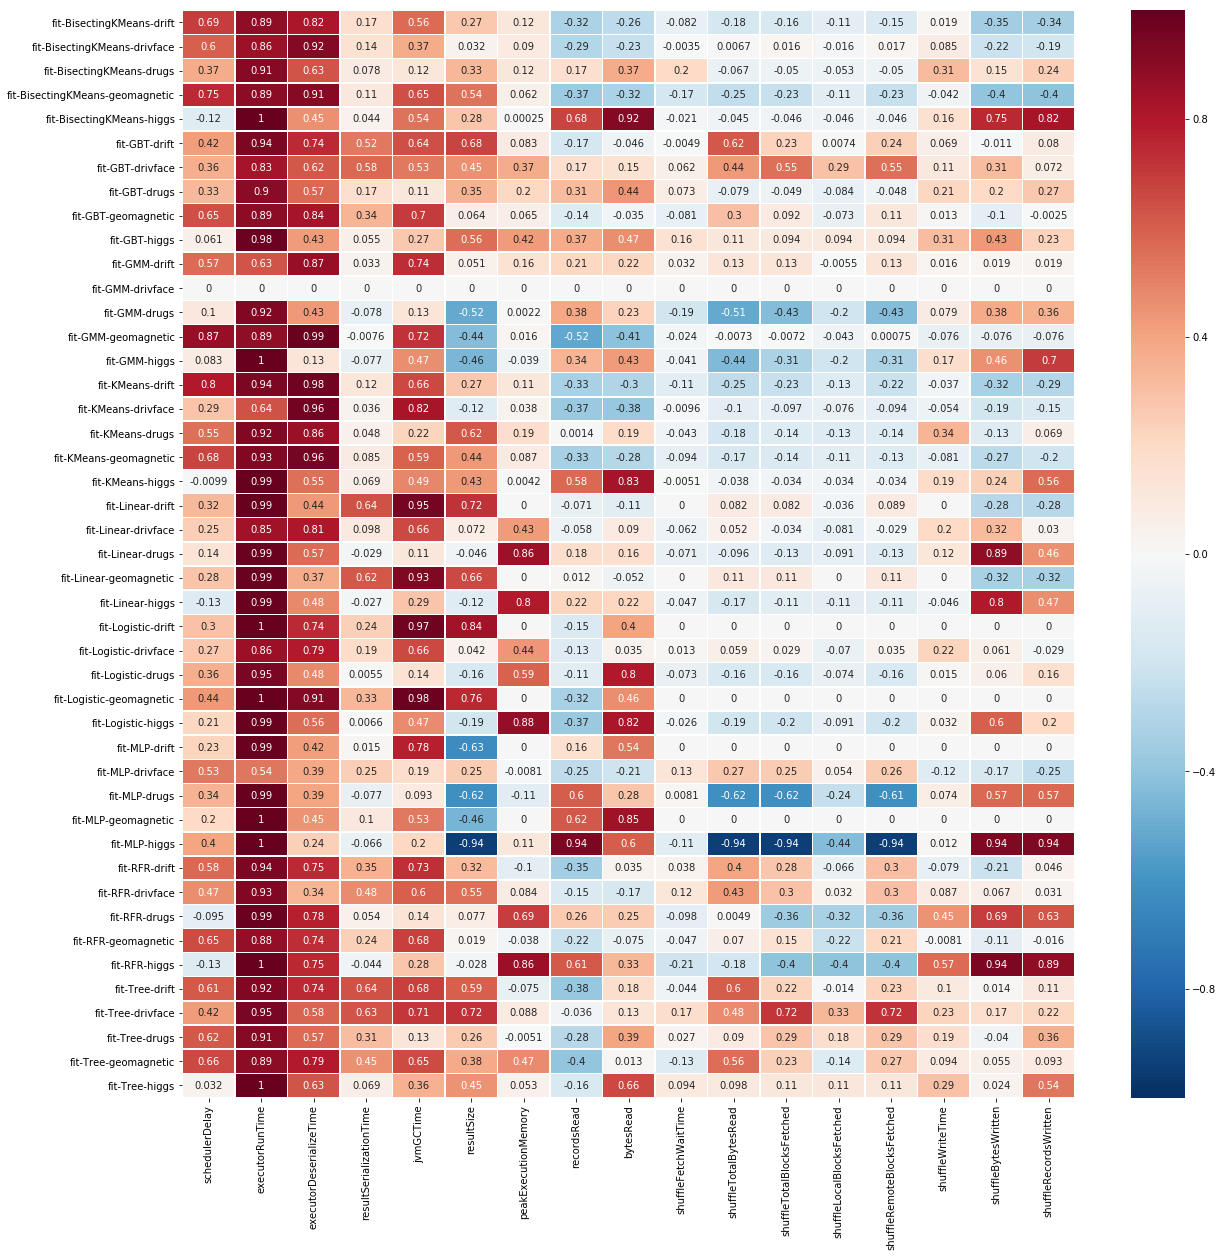

In [92]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr.T, vmax=1, vmin=-1, linewidths=.5, annot=True, cmap='RdBu_r')
plt.savefig('corr-fit-task-duration.eps', format='eps')

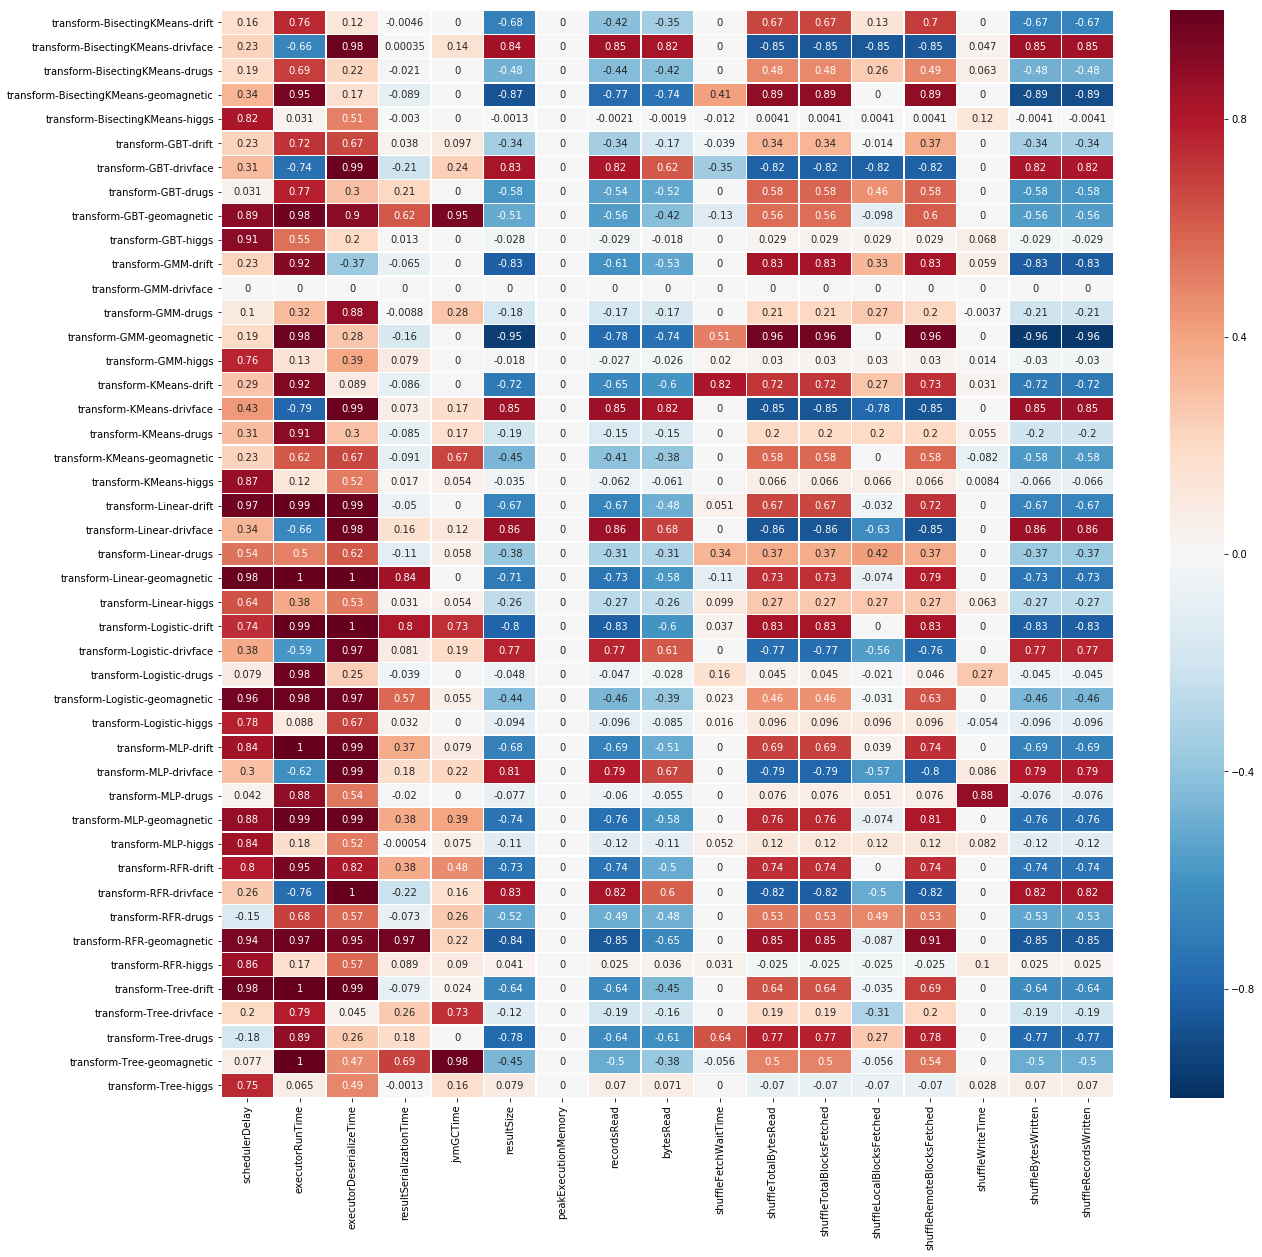

In [96]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr.T, vmax=1, vmin=-1, linewidths=.5, annot=True, cmap='RdBu_r')
plt.savefig('corr-transform-task-duration.eps', format='eps')

In [76]:
corr = correlations(small.drop(columns=['executorCpuTime', 'executorDeserializeCpuTime']), 'fitTime')
total = count(corr, k=4)

In [77]:
pd.Series(total).sort_values()

peakExecutionMemory           1
shuffleBytesWritten           1
resultSize                    2
shuffleLocalBlocksFetched    11
shuffleWriteTime             12
executorRunTime              19
resultSerializationTime      20
shuffleFetchWaitTime         23
jvmGCTime                    23
executorDeserializeTime      32
schedulerDelay               36
dtype: int64

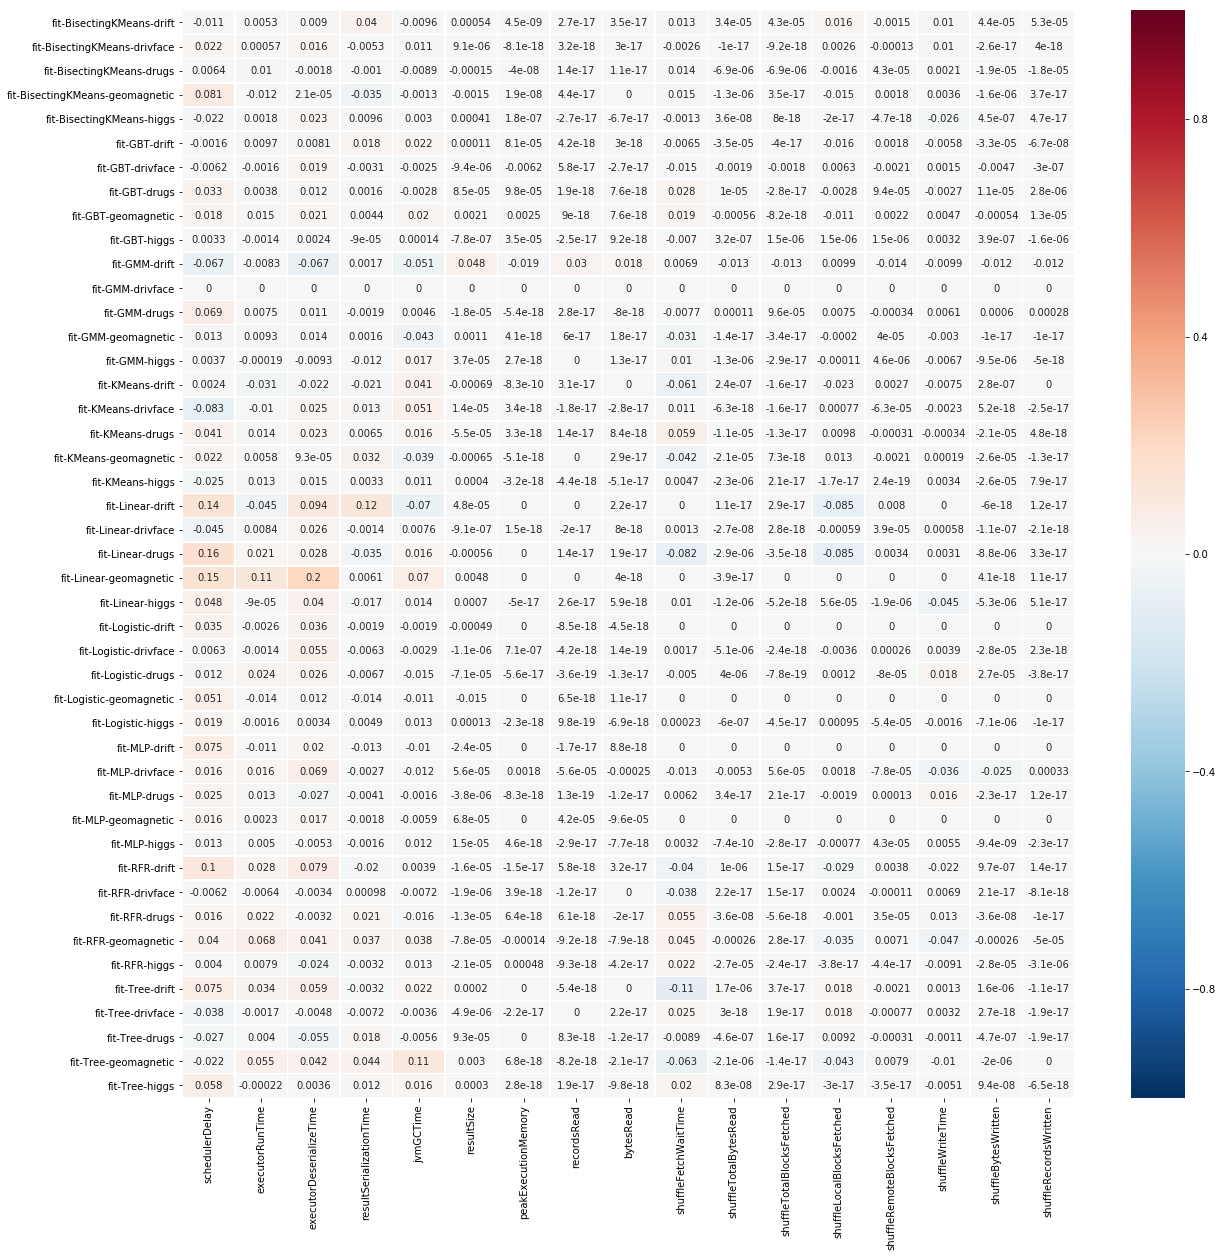

In [78]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr.T, vmax=1, vmin=-1, linewidths=.5, annot=True, cmap='RdBu_r')
plt.savefig('corr-fit-time.eps', format='eps')

In [68]:
pd.Series(total).sort_values()

shuffleFetchWaitTime          7
shuffleWriteTime              9
shuffleLocalBlocksFetched    15
jvmGCTime                    18
resultSerializationTime      27
executorRunTime              29
schedulerDelay               37
executorDeserializeTime      38
dtype: int64

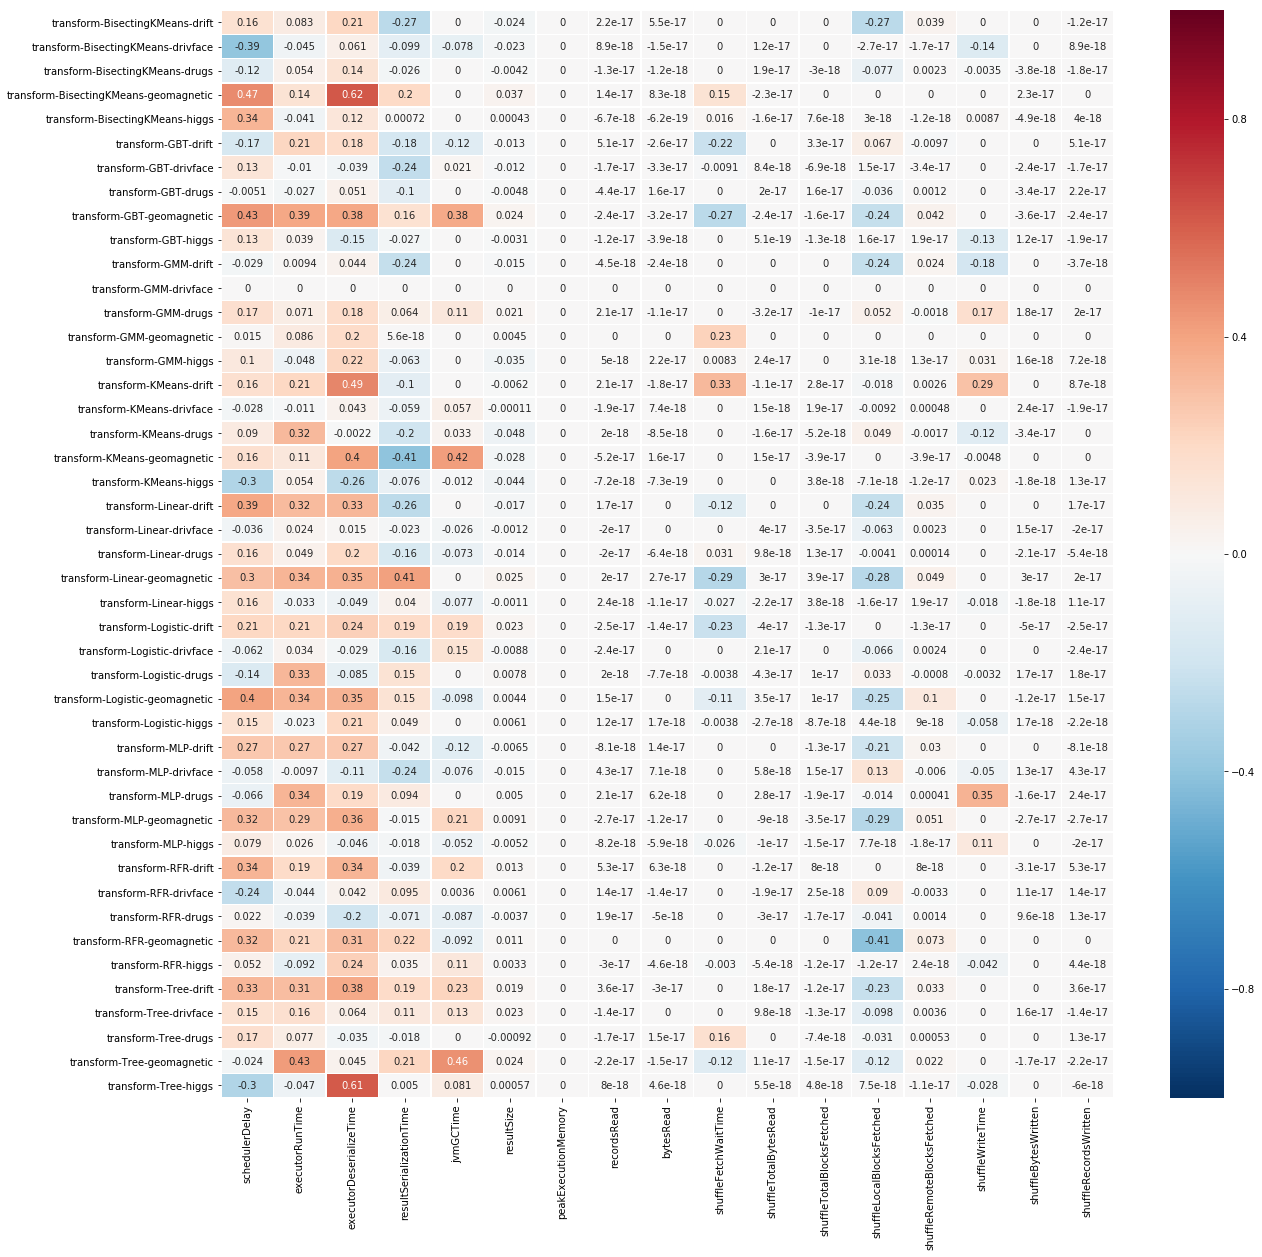

In [69]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr.T, vmax=1, vmin=-1, linewidths=.5, annot=True, cmap='RdBu_r')
plt.savefig('corr-transform-time.eps', format='eps')